# Compare vaccination strategies. $e$=0.7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime
from experiments import get_experiments_results
from env_var import EPIDEMIC, MAPPINGS, EXPERIMENTS

mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Simulation parameters
num_age_groups = EXPERIMENTS['num_age_groups']
num_ervas = EXPERIMENTS['num_ervas']
T = EXPERIMENTS['simulate_T']
init_vacc = EXPERIMENTS['init_vacc']
taus = EXPERIMENTS['taus']
u = EXPERIMENTS['vaccines_per_day']
r_experiments = EXPERIMENTS['r_effs']
t0 = EXPERIMENTS['t0']
e = EPIDEMIC['e']
strategies = EXPERIMENTS['strategies']

# Plot parameters
plot_interval = 15
ervas_labels = EPIDEMIC['ervas_order']
age_labels = MAPPINGS['age_groups'][num_age_groups]['names']
color_palette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

In [3]:
exp_results = get_experiments_results(num_age_groups=num_age_groups,
                                      num_ervas=num_ervas,
                                      init_vacc=init_vacc,
                                      strategies=strategies,
                                      u=u,
                                      T=T,
                                      r_experiments=r_experiments,
                                      t0=t0,
                                      e=e,
                                      taus=taus)

Beginning experiments.
Parameters:
Number of age ervas: 5.
Number of age groups: 9.
Number of vaccines per day: 30000.
t0: 2021-04-18.
T: 115.
Vaccine efficacy (e): 0.7.
Rs to try: [0.75, 1.0, 1.25, 1.5].
Taus to try: [0, 0.5, 1.0].
Initialize with vaccinated people: True.
Strategies:
[([1, 0, 0], 'Pop only'), ([0, 0, 0], 'No vaccination'), ([0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 'Pop, Inf and Hosp'), ([0.5, 0, 0.5], 'Pop and Hosp'), ([0.5, 0.5, 0], 'Pop and Inf'), ([0, 0.5, 0.5], 'Hosp and Inf'), ([0, 0, 1], 'Hosp only'), ([0, 1, 0], 'Inf only'), (None, 'Optimal')].

Running 108 experiments with 4 CPUS.
Start (43880). Exp: 2. R: 0.75. tau: 0. Policy: No vaccinationStart (43879). Exp: 1. R: 0.75. tau: 0. Policy: Pop onlyStart (43881). Exp: 3. R: 0.75. tau: 0. Policy: Pop, Inf and HospStart (43882). Exp: 4. R: 0.75. tau: 0. Policy: Pop and Hosp



Finished (43880). Exp: 2. Elapsed: 0:00:03.559470
Start (43880). Exp: 5. R: 0.75. tau: 0. Policy: Pop and Inf
Finished

Start (43880). Exp: 60. R: 1.25. tau: 0.5. Policy: Hosp and Inf
Finished (43881). Exp: 57. Elapsed: 0:00:03.433298
Start (43881). Exp: 61. R: 1.25. tau: 0.5. Policy: Hosp only
Finished (43879). Exp: 58. Elapsed: 0:00:03.350428
Start (43879). Exp: 62. R: 1.25. tau: 0.5. Policy: Inf only
Finished (43882). Exp: 59. Elapsed: 0:00:03.627877
Start (43882). Exp: 63. R: 1.25. tau: 0.5. Policy: Optimal
Finished (43880). Exp: 60. Elapsed: 0:00:03.810171
Start (43880). Exp: 91. R: 1.25. tau: 1.0. Policy: Pop only
Finished (43881). Exp: 61. Elapsed: 0:00:03.871796
Start (43881). Exp: 92. R: 1.25. tau: 1.0. Policy: No vaccination
Finished (43879). Exp: 62. Elapsed: 0:00:03.871069
Start (43879). Exp: 93. R: 1.25. tau: 1.0. Policy: Pop, Inf and Hosp
Finished (43882). Exp: 63. Elapsed: 0:00:03.666874
Start (43882). Exp: 94. R: 1.25. tau: 1.0. Policy: Pop and Hosp
Finished (43880). Exp: 91. Elapsed: 0:00:03.395560
Start (43880). Exp: 95. R: 1.25. tau: 1.0. Policy: Pop and Inf
Finished (43881). Exp: 92.

In [11]:
def plot_results(ax, r, tau, metric, exp_results, t0, T, baseline='Pop only', skip_no_vacc=True):
    begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
    x = [begin + datetime.timedelta(days=day) for day in range(T)]

    results = exp_results[r][tau]
    label_i = 0
    for label, label_level in results.items():
        if label == baseline:
            baseline_results = label_level['results'][metric]
            baseline_all_time = baseline_results.sum(axis=0)
            baseline_all_time = baseline_all_time.sum(axis=0)
    
    assert baseline_all_time is not None
    assert baseline_all_time.shape[0] == T
    
    totals = []
    label_i = 0
    for label, label_level in results.items():
        if label == baseline:
            continue

        if label == 'No vaccination' and skip_no_vacc:
            continue
            
        metric_results = label_level['results'][metric]
        metric_all_time = metric_results.sum(axis=0)
        metric_all_time = metric_all_time.sum(axis=0)
        
        assert metric_all_time.shape[0] == T
        
        plot_metric = metric_all_time/baseline_all_time
        plot_metric = np.nan_to_num(plot_metric, nan=1)
        plot_metric = plot_metric - 1
        plot_metric = plot_metric*100
        
        color = label_i % len(color_palette)
        ax.plot(x, plot_metric, label=label, color=color_palette[color])
        if metric == 'deaths':
            baseline_policy = baseline_all_time[-1]
            total_policy = metric_all_time[-1]
        else:
            baseline_policy = baseline_all_time.sum(axis=0)
            total_policy = metric_all_time.sum(axis=0)
        rel_total = ((total_policy/baseline_policy)-1)*100
        total = (label, rel_total)
        totals.append(total)
        label_i += 1
        
    sorted_totals = sorted(totals, key=lambda x: x[-1])
    for total in sorted_totals:
        print('%s: %s' % (total[0], total[1]))
        
    ax.set_xlabel('Date')
    ax.set_ylabel('Relative number of {0} (%)'.format(metric))
    ax.set_title('Relative number of %s compared to %s. R=%s. tau=%s' % (metric, baseline, r, tau))
    ax.legend()
        
    return ax

# Deaths

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: i

Optimal: -1.8457352470158561
Pop and Inf: 0.47038888677306545
Pop and Hosp: 0.8070385293308391
Pop, Inf and Hosp: 1.3290102555463923
Inf only: 2.6751807485229095
Hosp and Inf: 2.9933511653206013
Hosp only: 3.3516072590923374


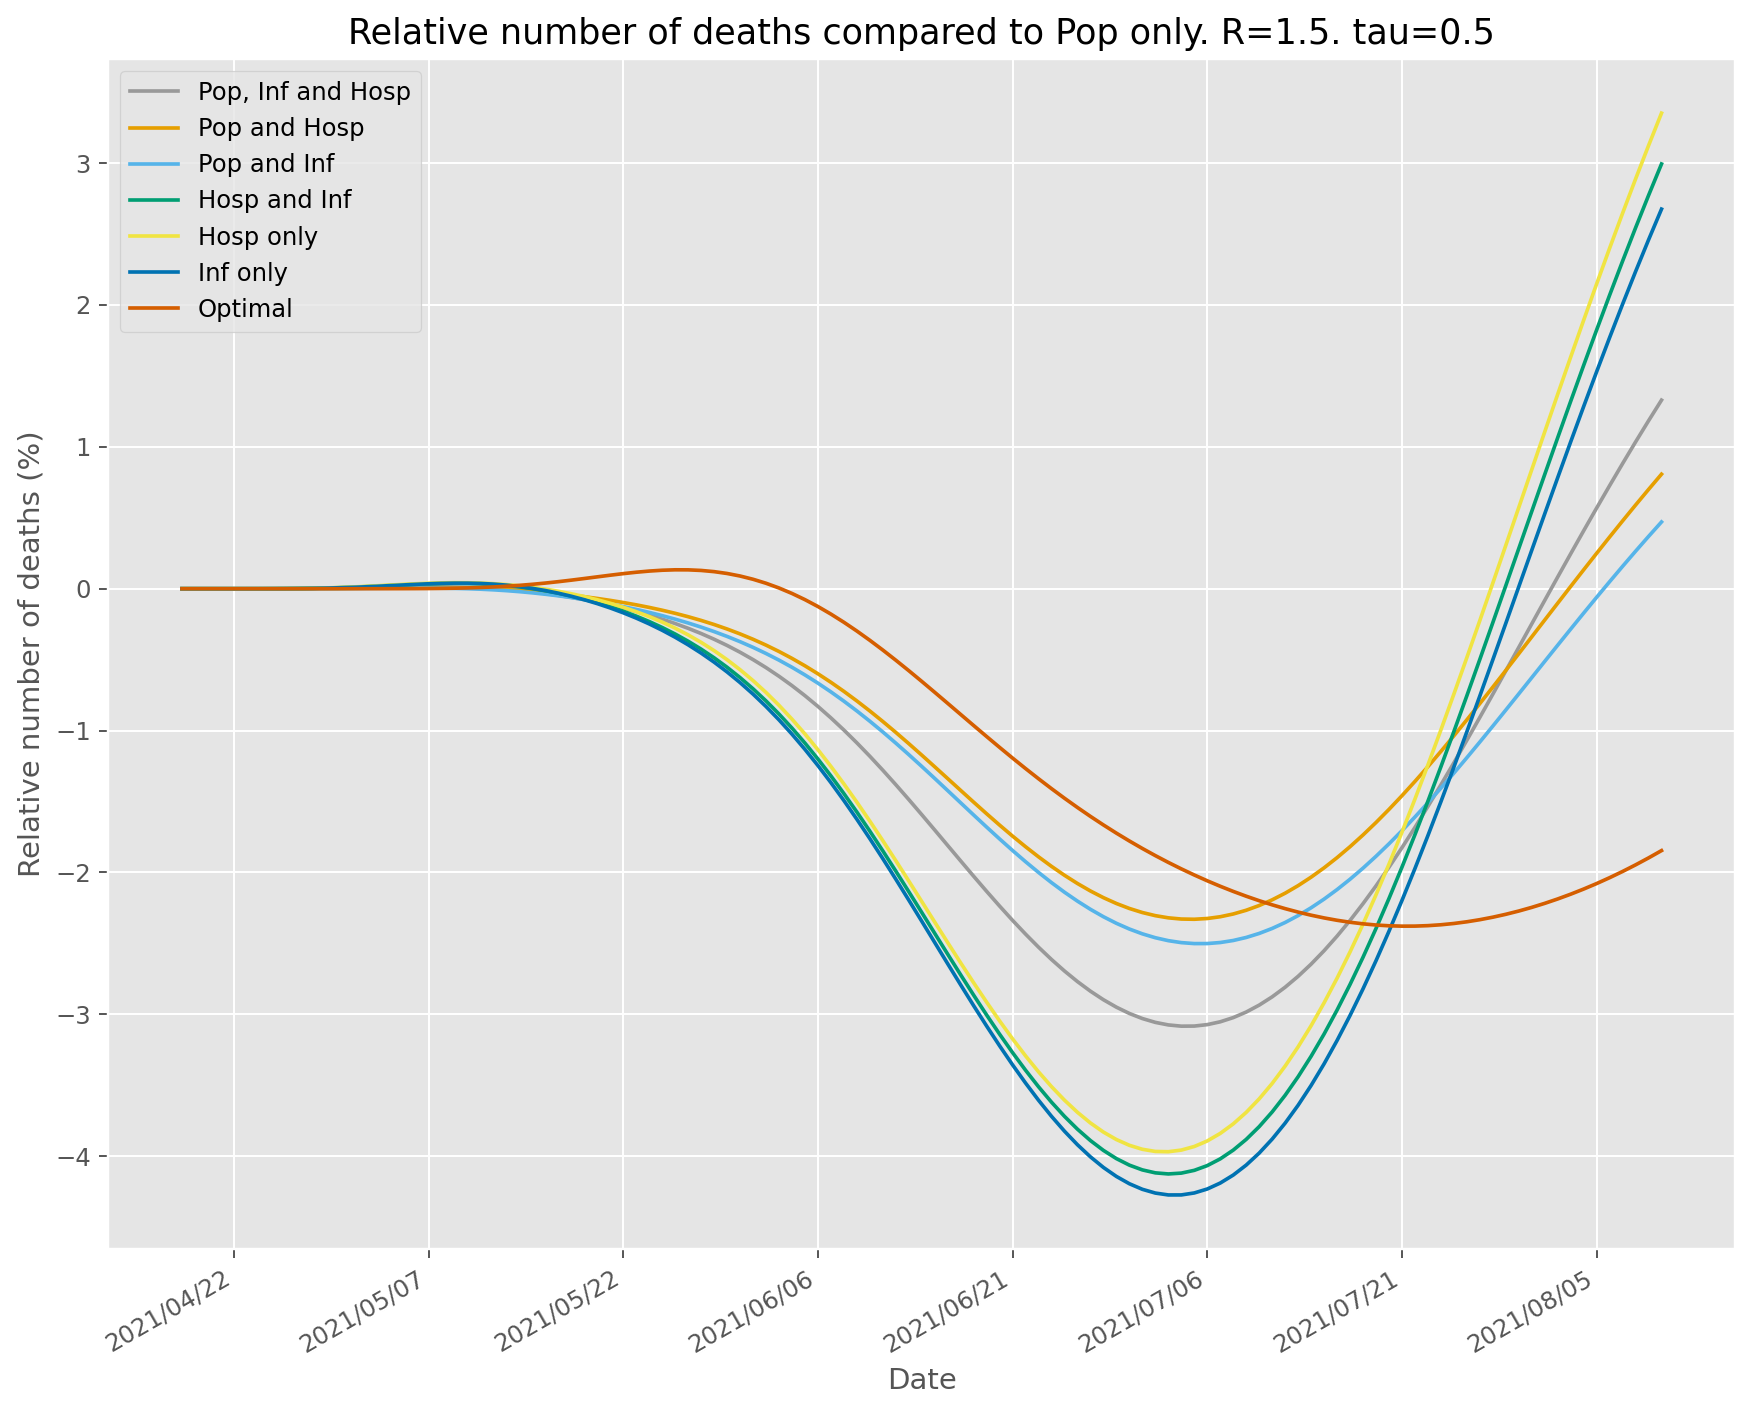

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=1.5, tau=0.5, metric='deaths', exp_results=exp_results, t0=t0, T=T)

fig.autofmt_xdate()

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: i

Inf only: -2.0588265532913153
Optimal: -2.014842554512275
Hosp and Inf: -1.9607182138547952
Hosp only: -1.8477934652330608
Pop, Inf and Hosp: -1.5645692523187593
Pop and Inf: -1.3337858041931994
Pop and Hosp: -1.23241877921757


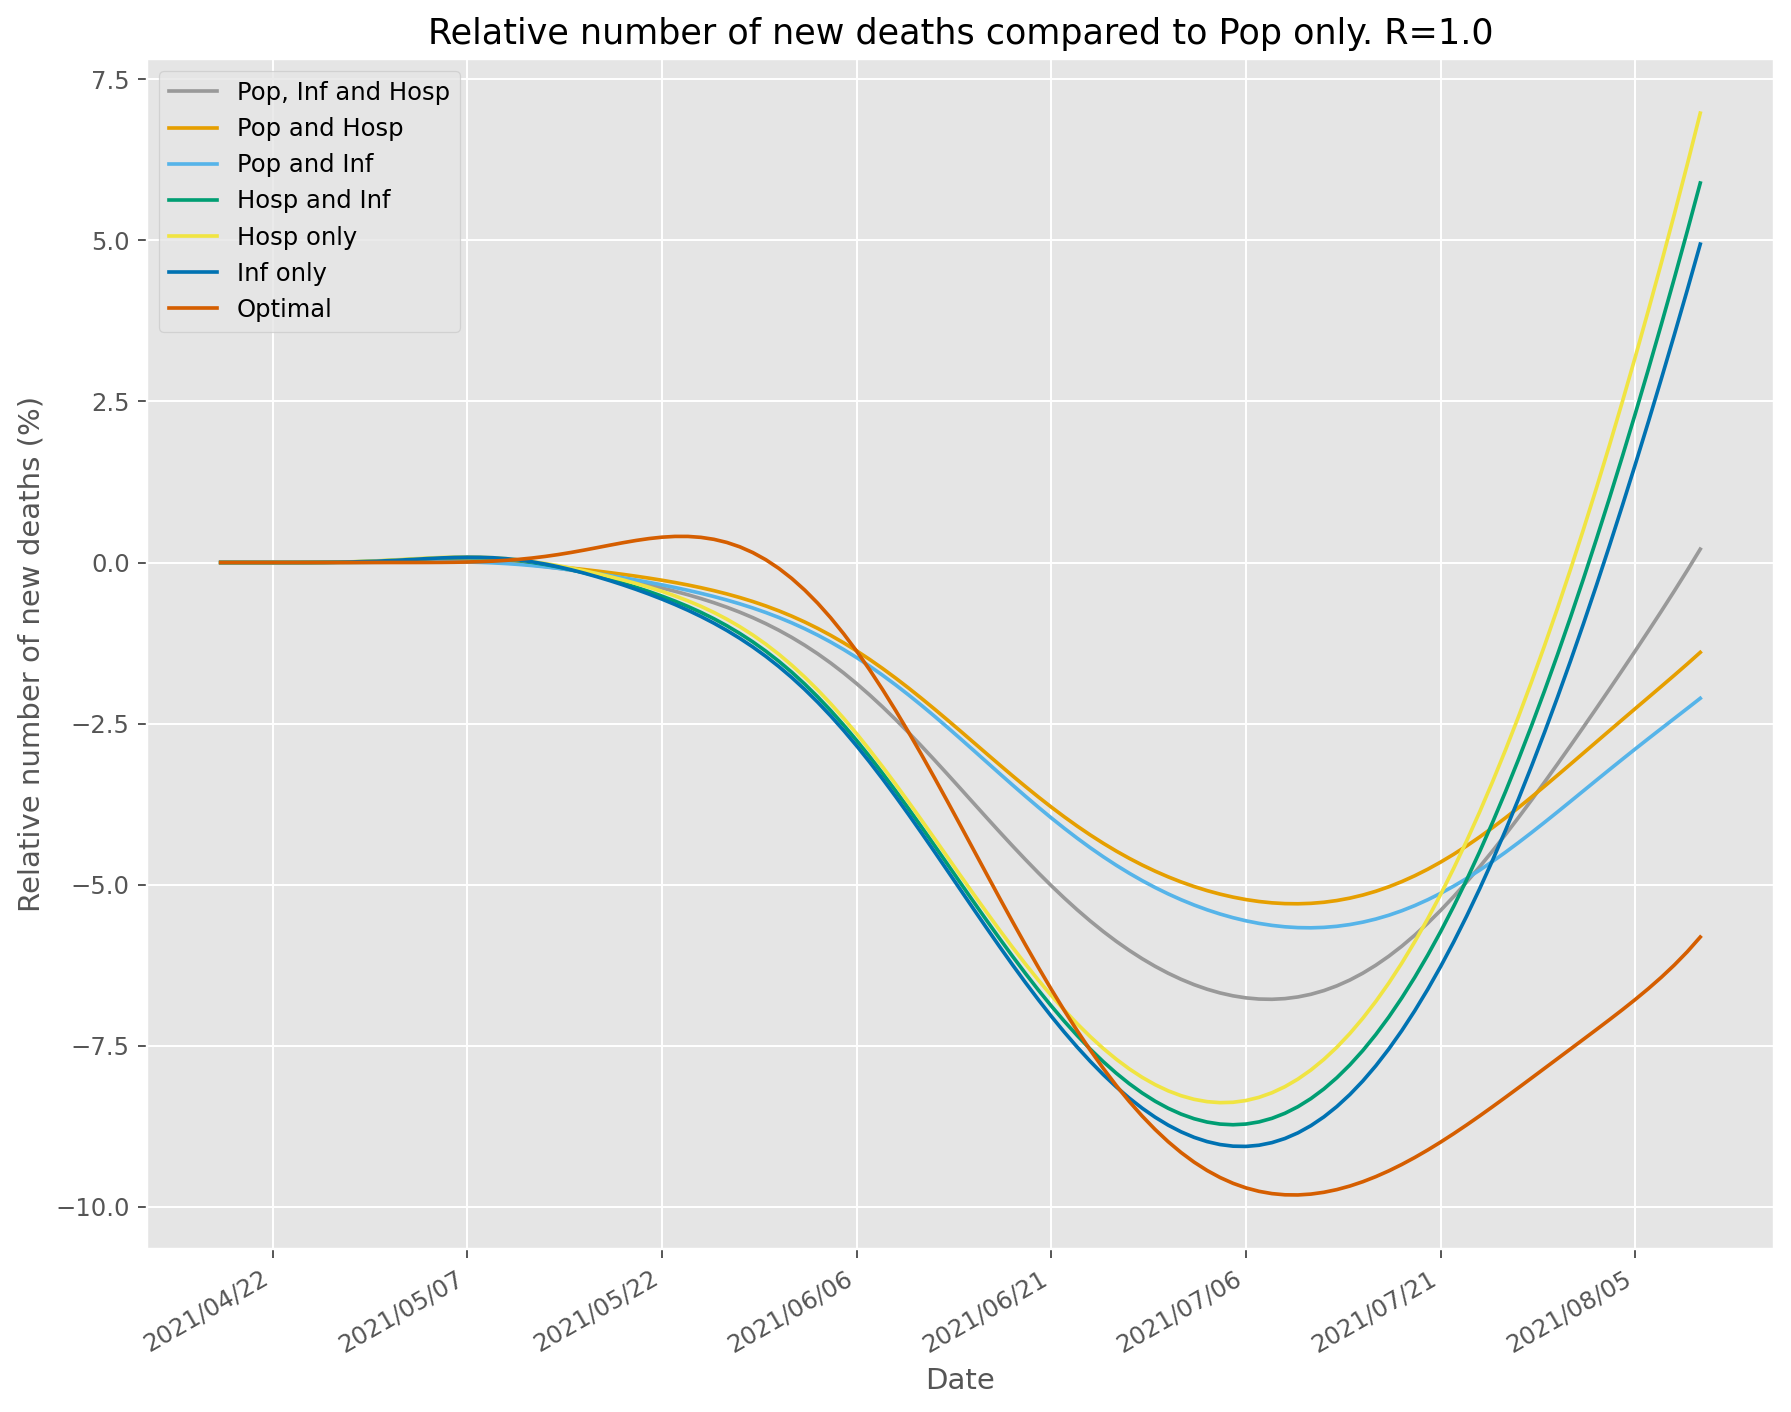

In [27]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: i

Optimal: -4.013011011615674
Inf only: -2.064381922688907
Pop and Inf: -1.9856967822775462
Pop, Inf and Hosp: -1.9651203125586325
Hosp and Inf: -1.785231606845461
Pop and Hosp: -1.7183023395257124
Hosp only: -1.4783600245999229


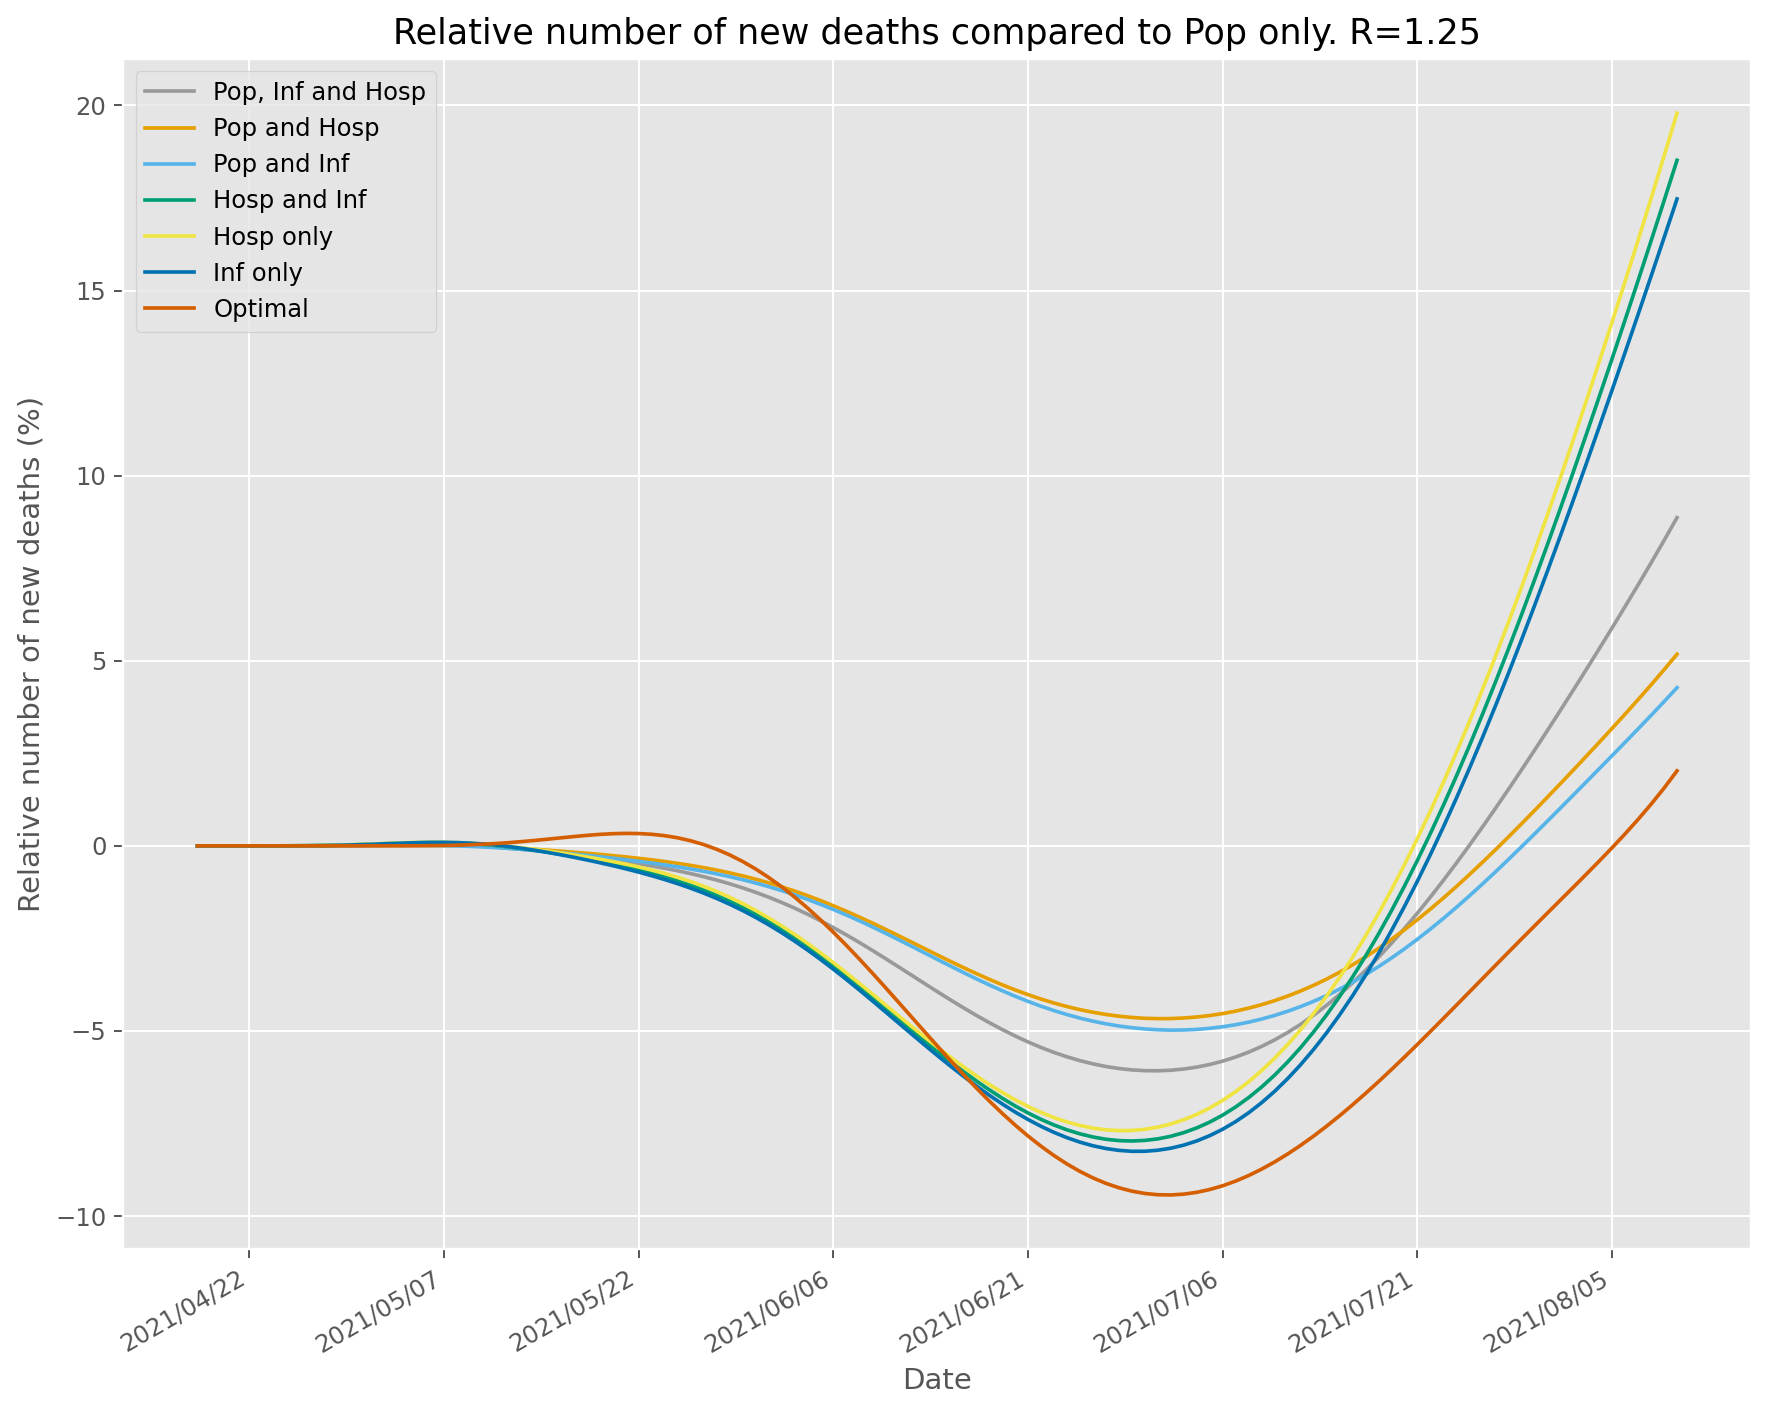

In [28]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: i

Optimal: -1.845735247015834
Pop and Inf: 0.47038888677308766
Pop and Hosp: 0.8070385293308613
Pop, Inf and Hosp: 1.32901025554637
Inf only: 2.6751807485229095
Hosp and Inf: 2.9933511653206013
Hosp only: 3.3516072590923596


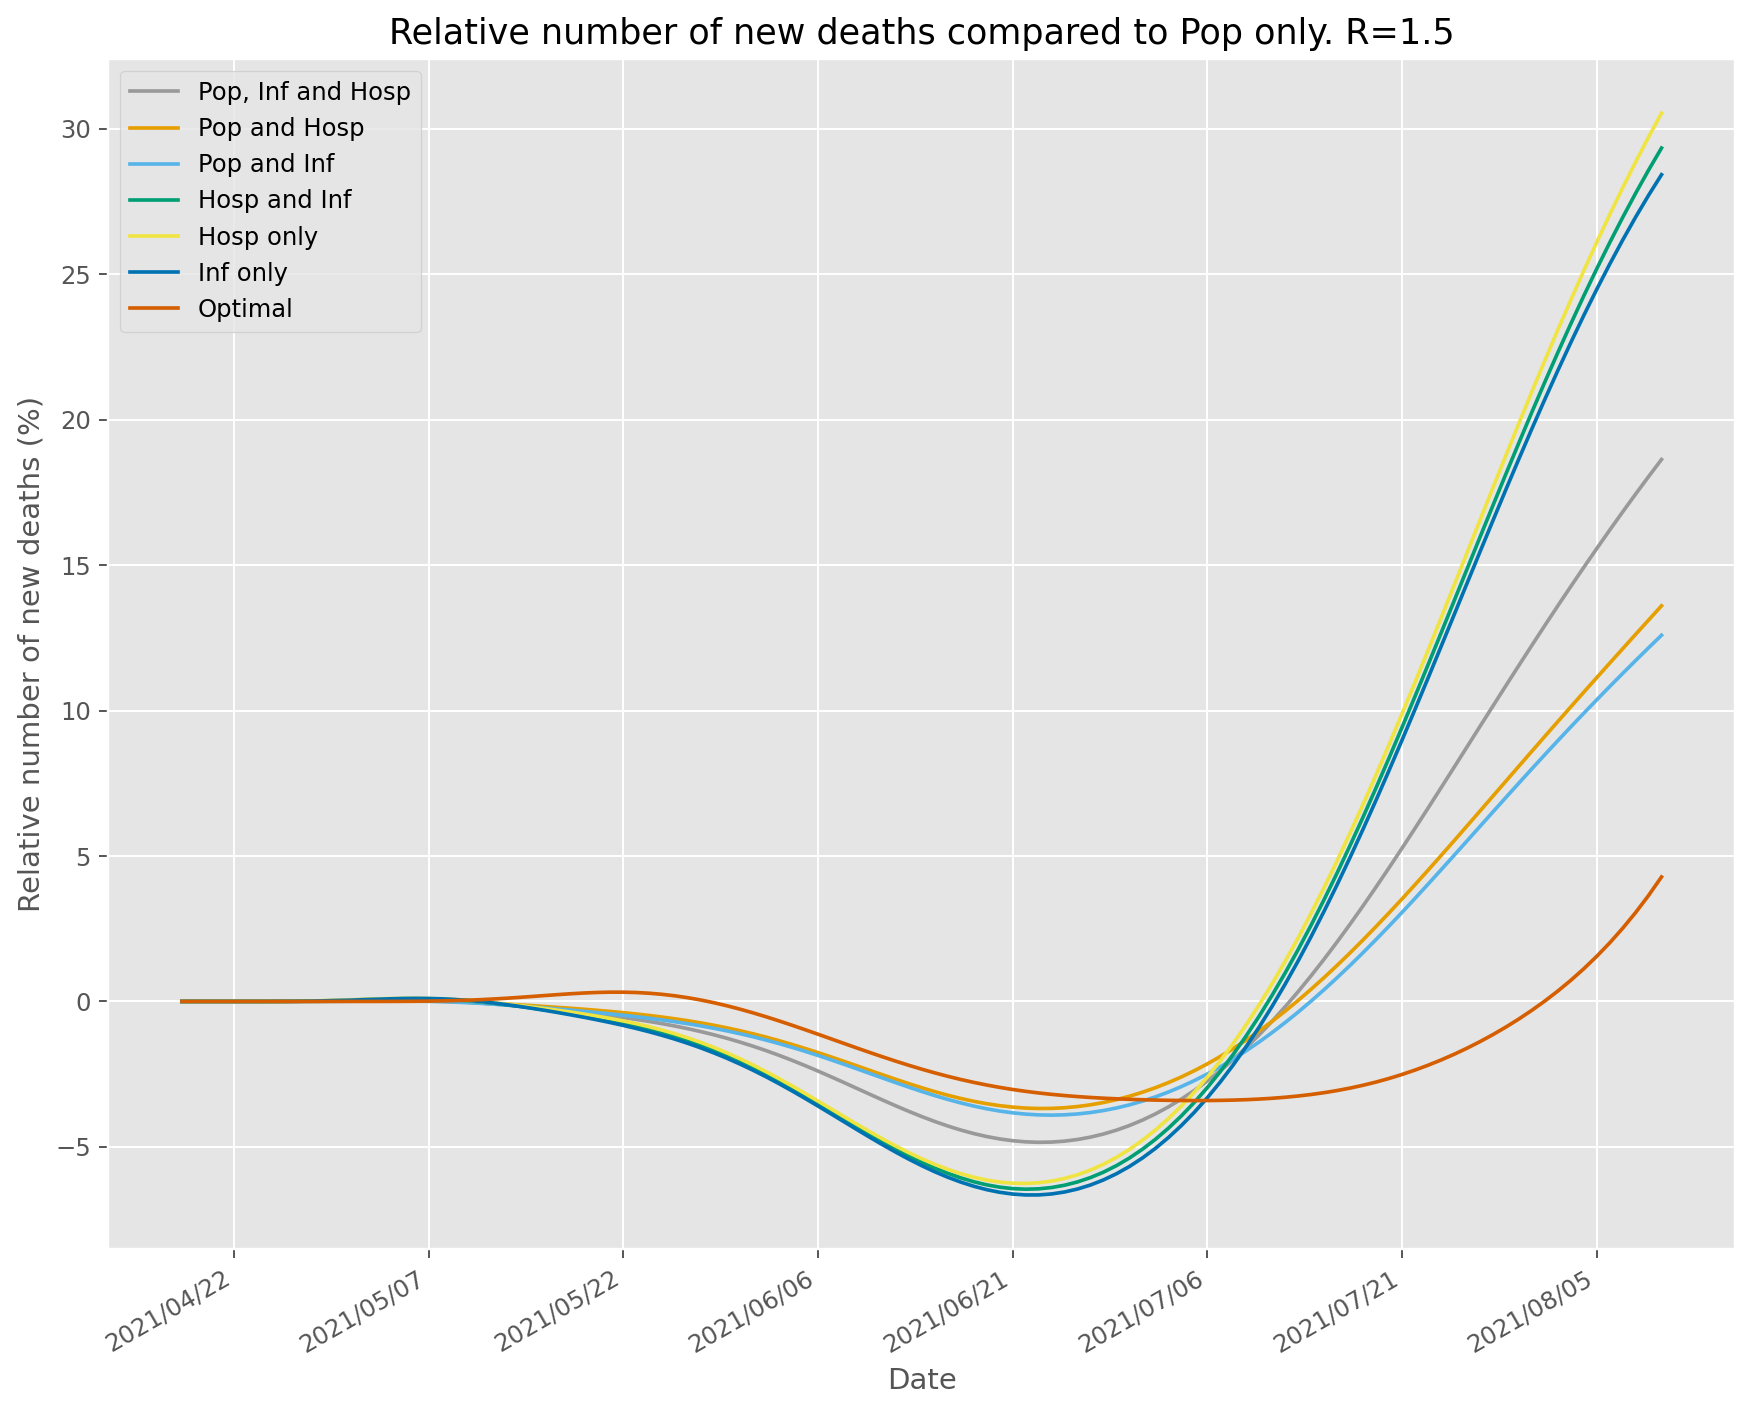

In [29]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[3], metric='new deaths', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

# Hospitalizations

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: i

Inf only: -1.9219978538454252
Hosp and Inf: -1.8617586327345448
Hosp only: -1.7960768948479977
Pop, Inf and Hosp: -1.3821447497927353
Pop and Inf: -1.118959494976135
Pop and Hosp: -1.0683929906315726
Optimal: -0.7783113998250157


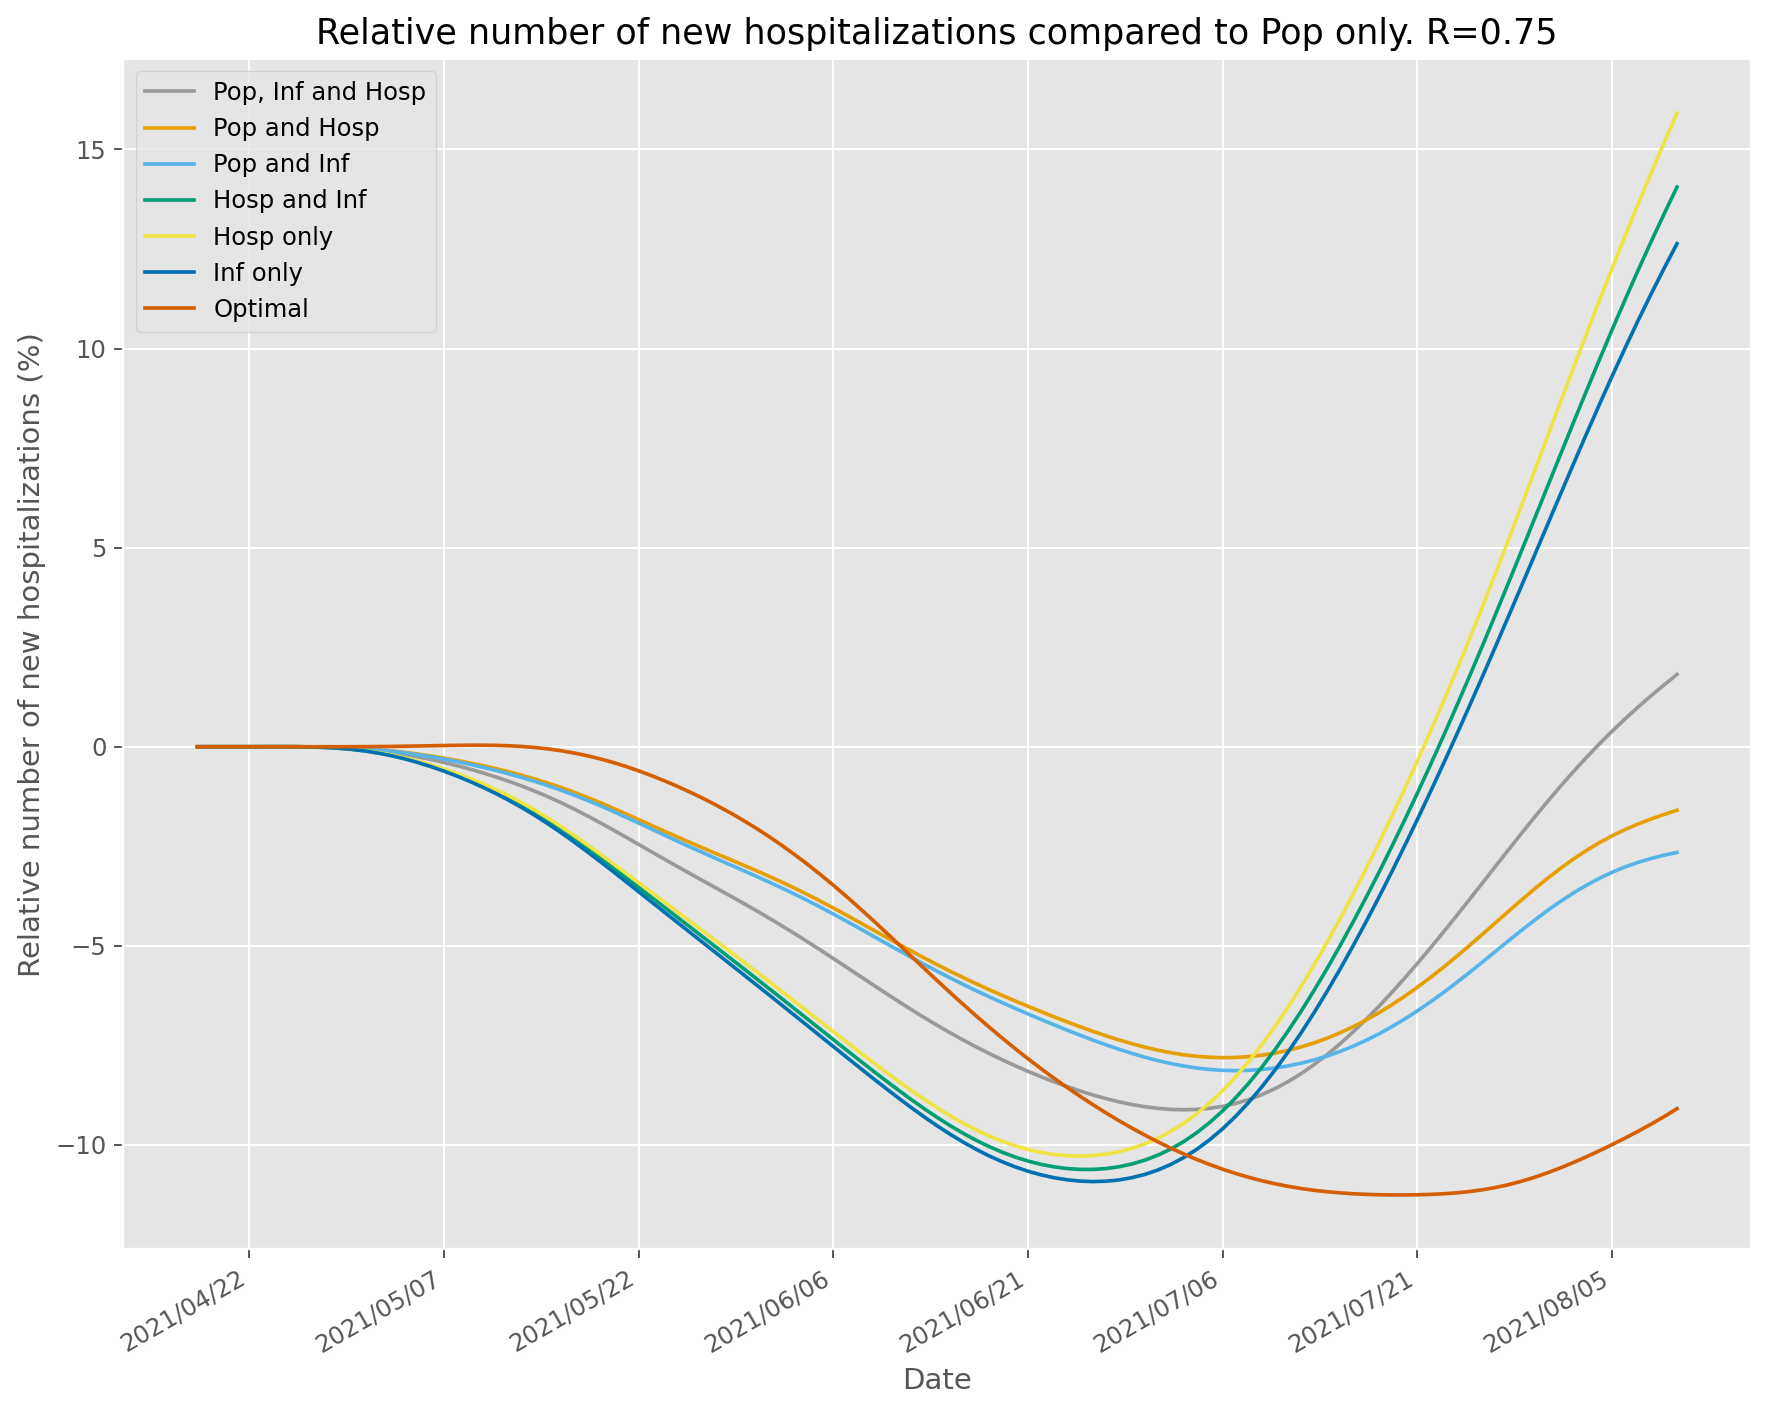

In [30]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='new hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: i

Inf only: -3.6272924400627904
Hosp and Inf: -3.468204206376446
Hosp only: -3.2837419598311657
Pop, Inf and Hosp: -3.020585023739486
Pop and Inf: -2.638899345622092
Pop and Hosp: -2.505959486235987
Optimal: -1.3713188273358212


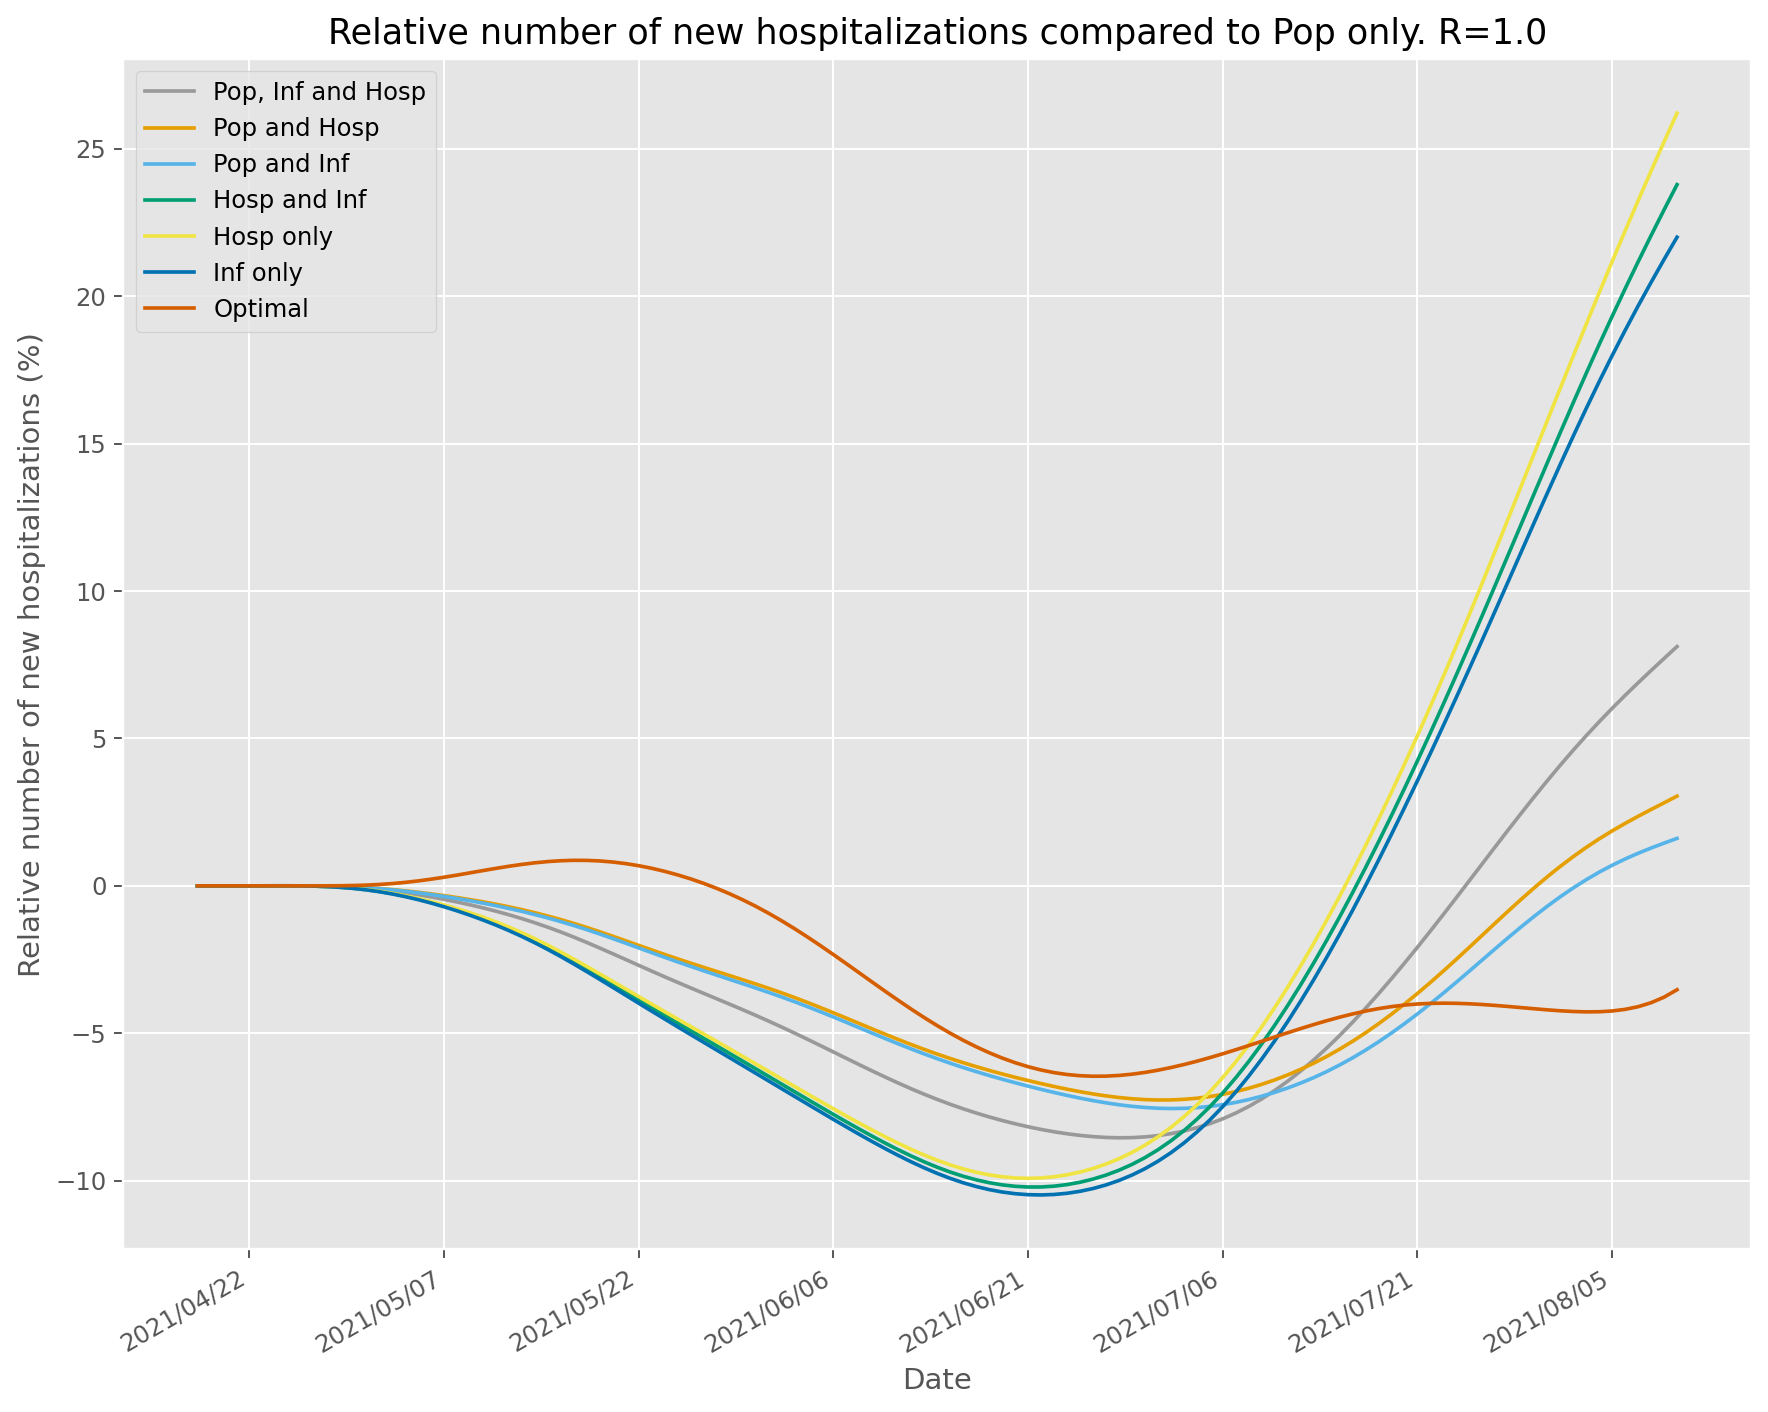

In [31]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='new hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: i

Pop and Inf: -2.547816723895102
Pop and Hosp: -2.218545816423323
Pop, Inf and Hosp: -2.0979994287769976
Optimal: -0.9599793620747143
Inf only: -0.8465685573536552
Hosp and Inf: -0.4931037604652855
Hosp only: -0.04783020497926005


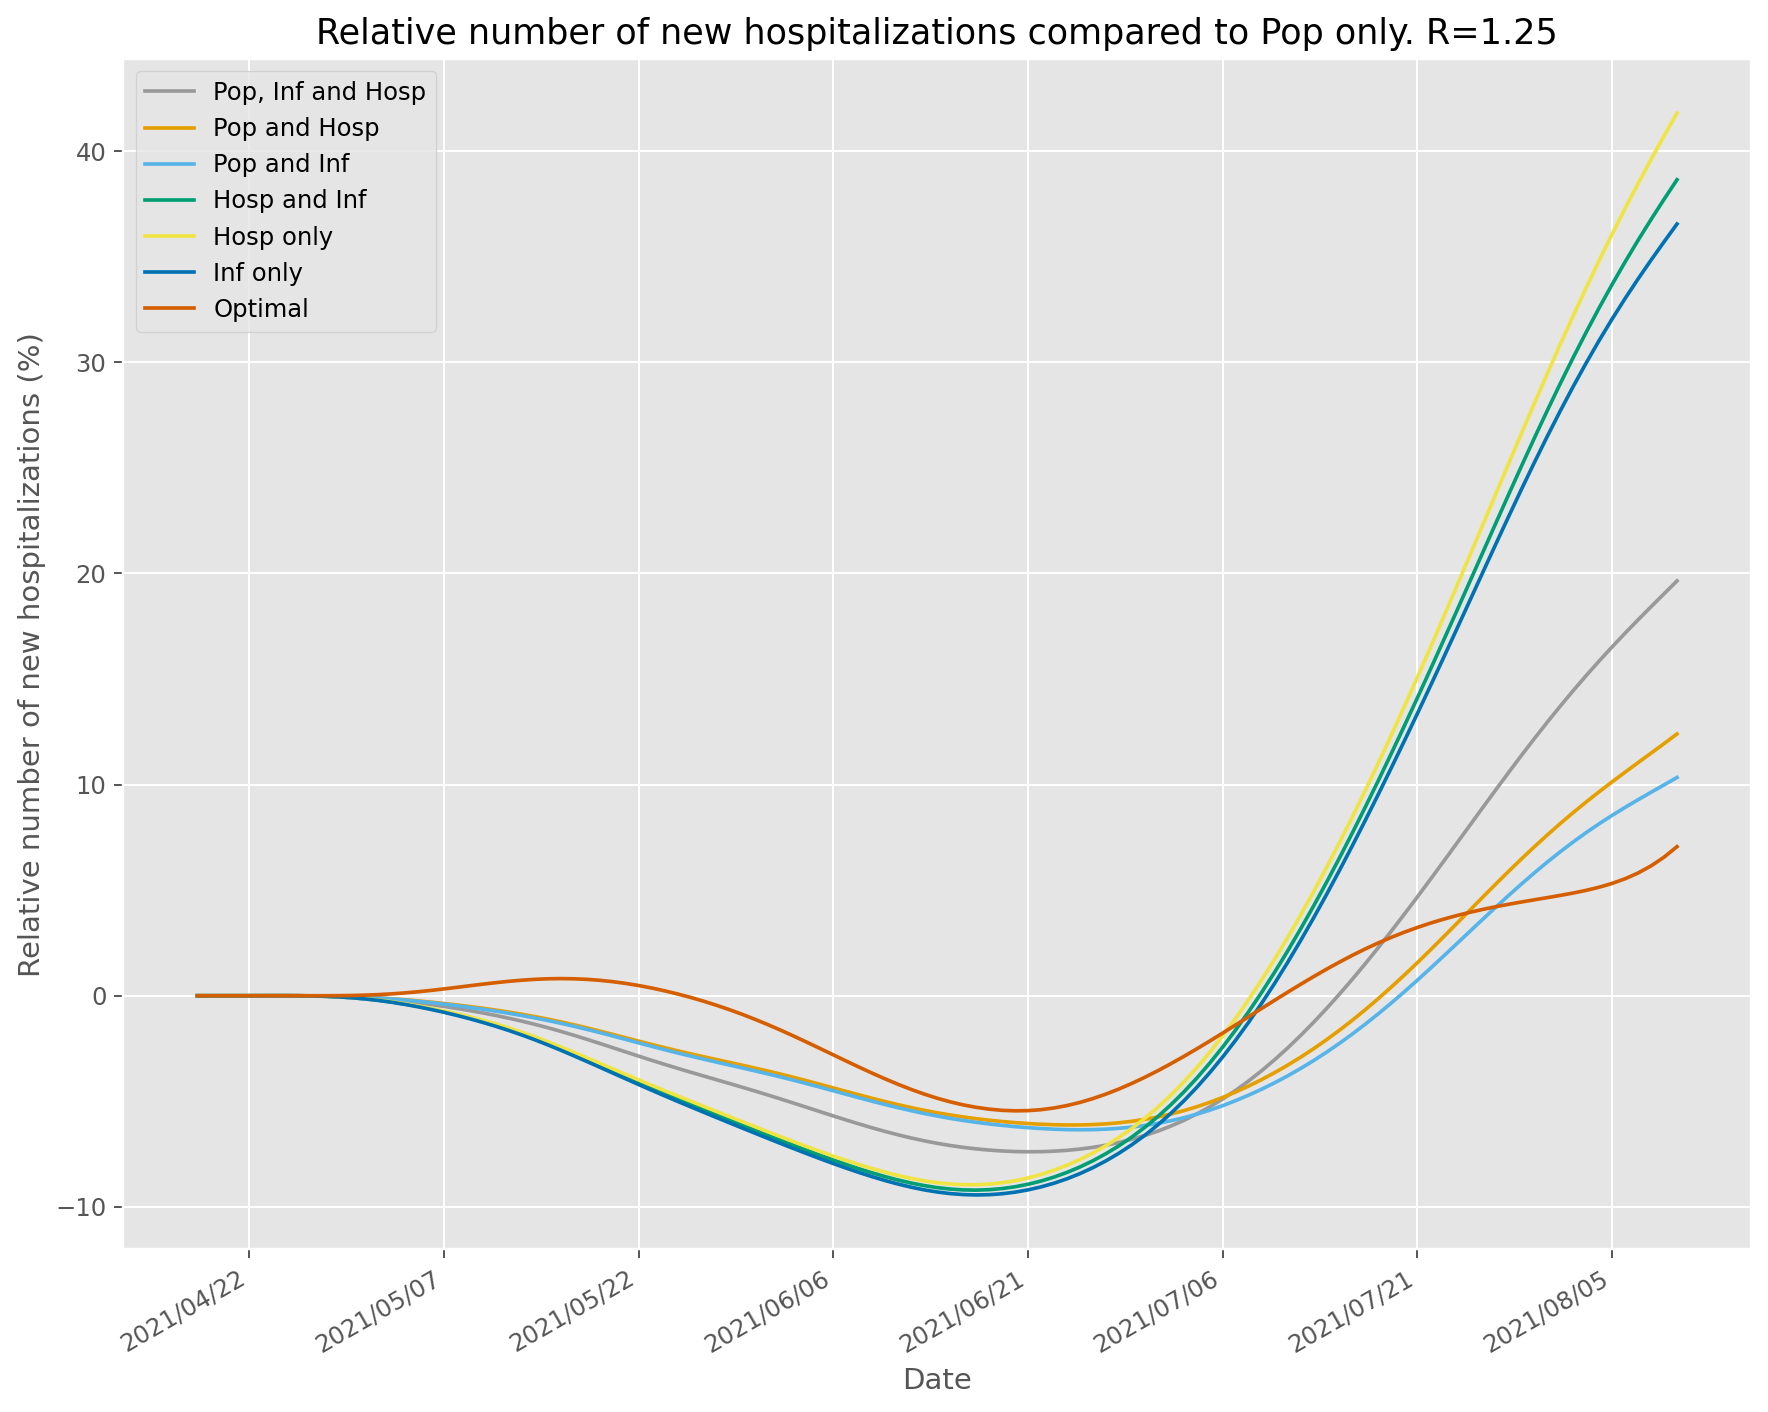

In [32]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='new hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: i

Optimal: 0.45217251173848005
Pop and Inf: 0.8217791845177125
Pop and Hosp: 1.2648478332679236
Pop, Inf and Hosp: 2.3971040292104506
Inf only: 5.601806630388828
Hosp and Inf: 6.012096998575478
Hosp only: 6.554254785952329


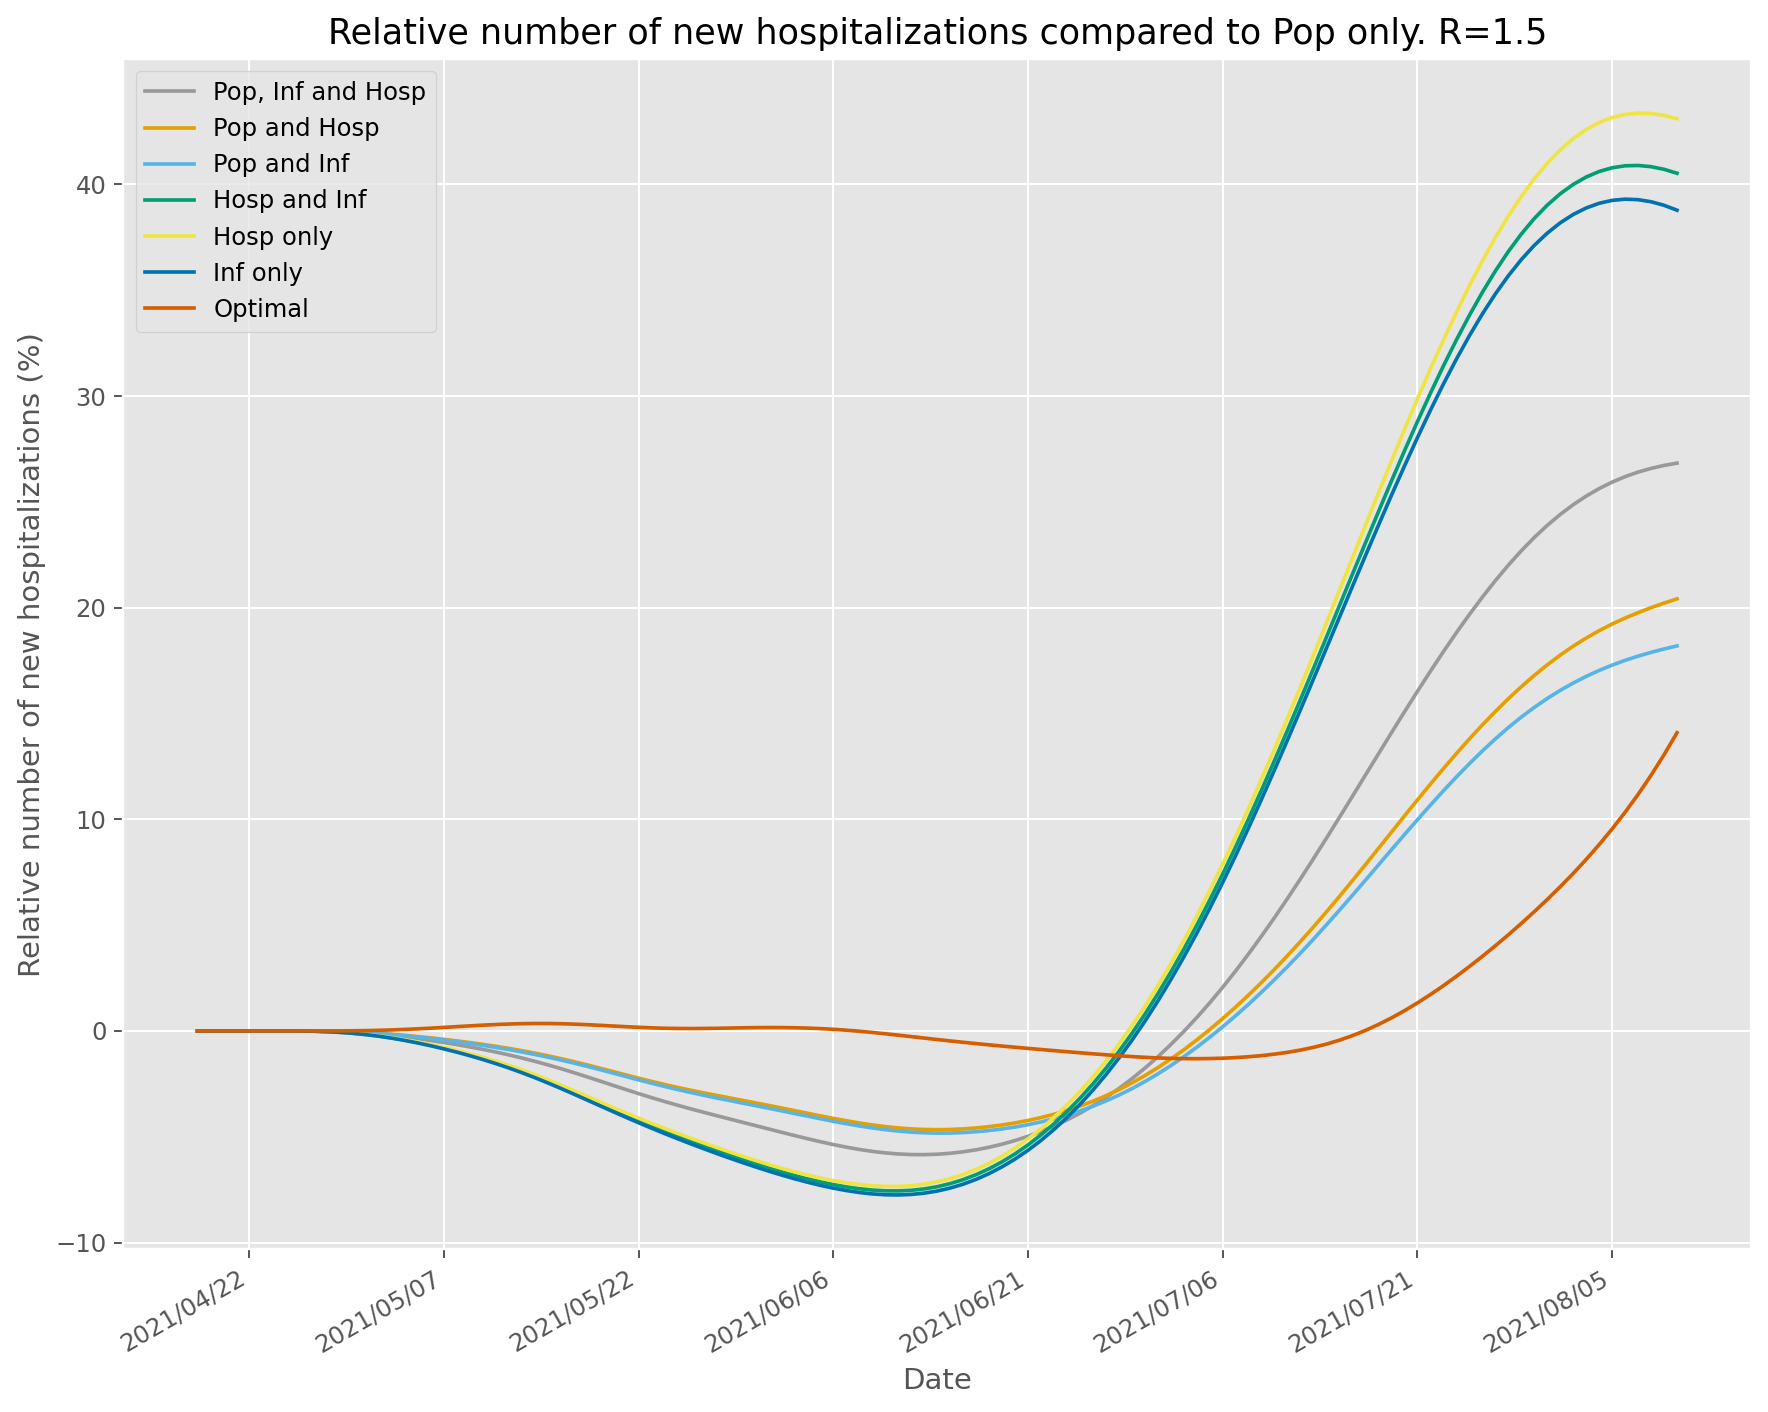

In [33]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[3], metric='new hospitalizations', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

# Infections

Optimal: -2.5960651867729445
Inf only: -2.0654891702873157
Hosp and Inf: -2.0422098165559843
Hosp only: -2.0239984274727396
Pop, Inf and Hosp: -1.3929589750810822
Pop and Inf: -1.0685974949162236
Pop and Hosp: -1.053717688123157


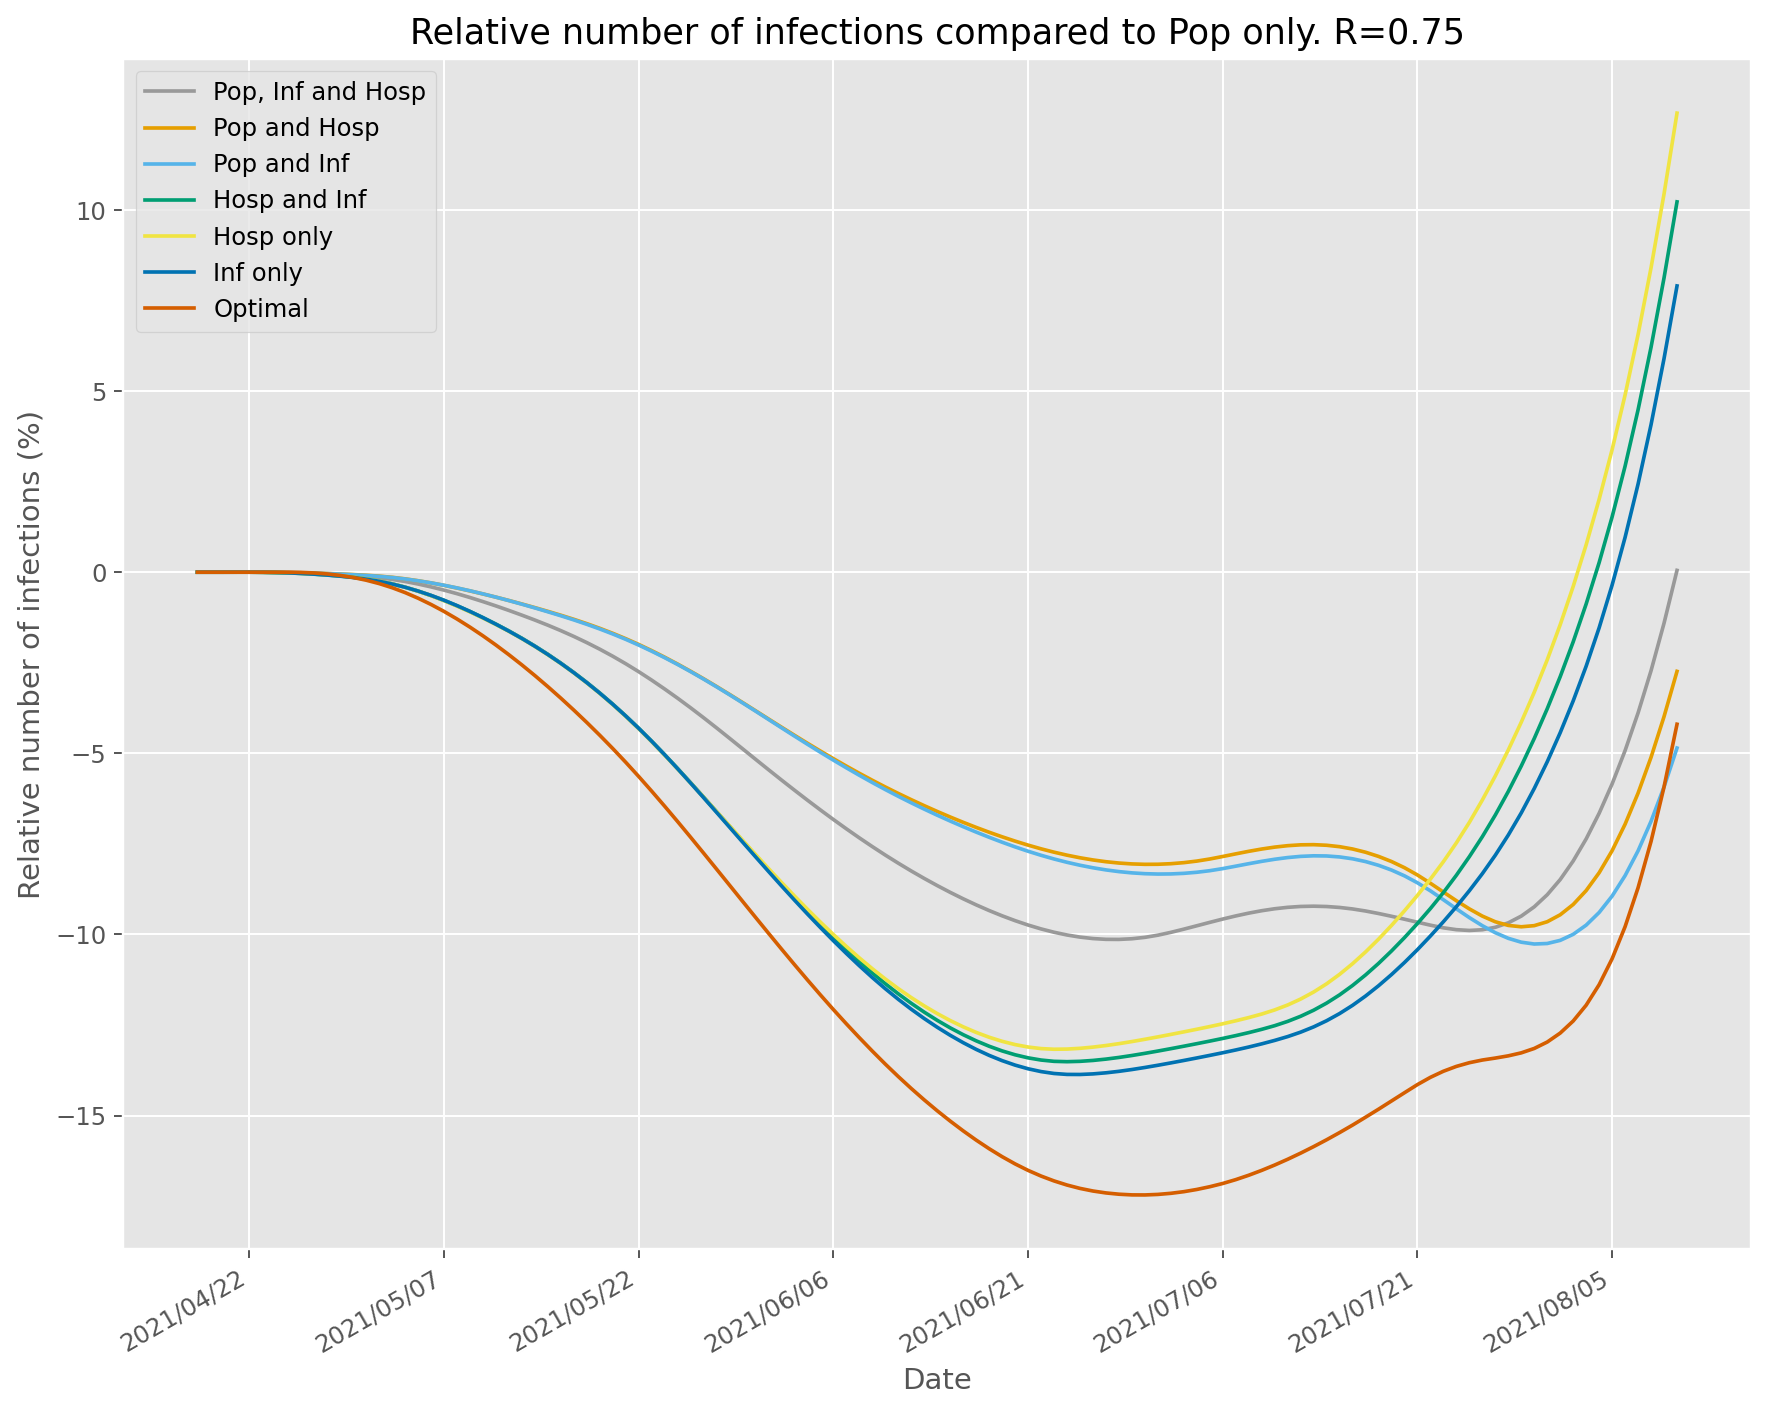

In [34]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[0], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Optimal: -8.261170996608325
Inf only: -4.827213244077222
Hosp and Inf: -4.6856823757179145
Hosp only: -4.5457590671444725
Pop, Inf and Hosp: -3.500328089736382
Pop and Inf: -2.865102717583512
Pop and Hosp: -2.778602309230882


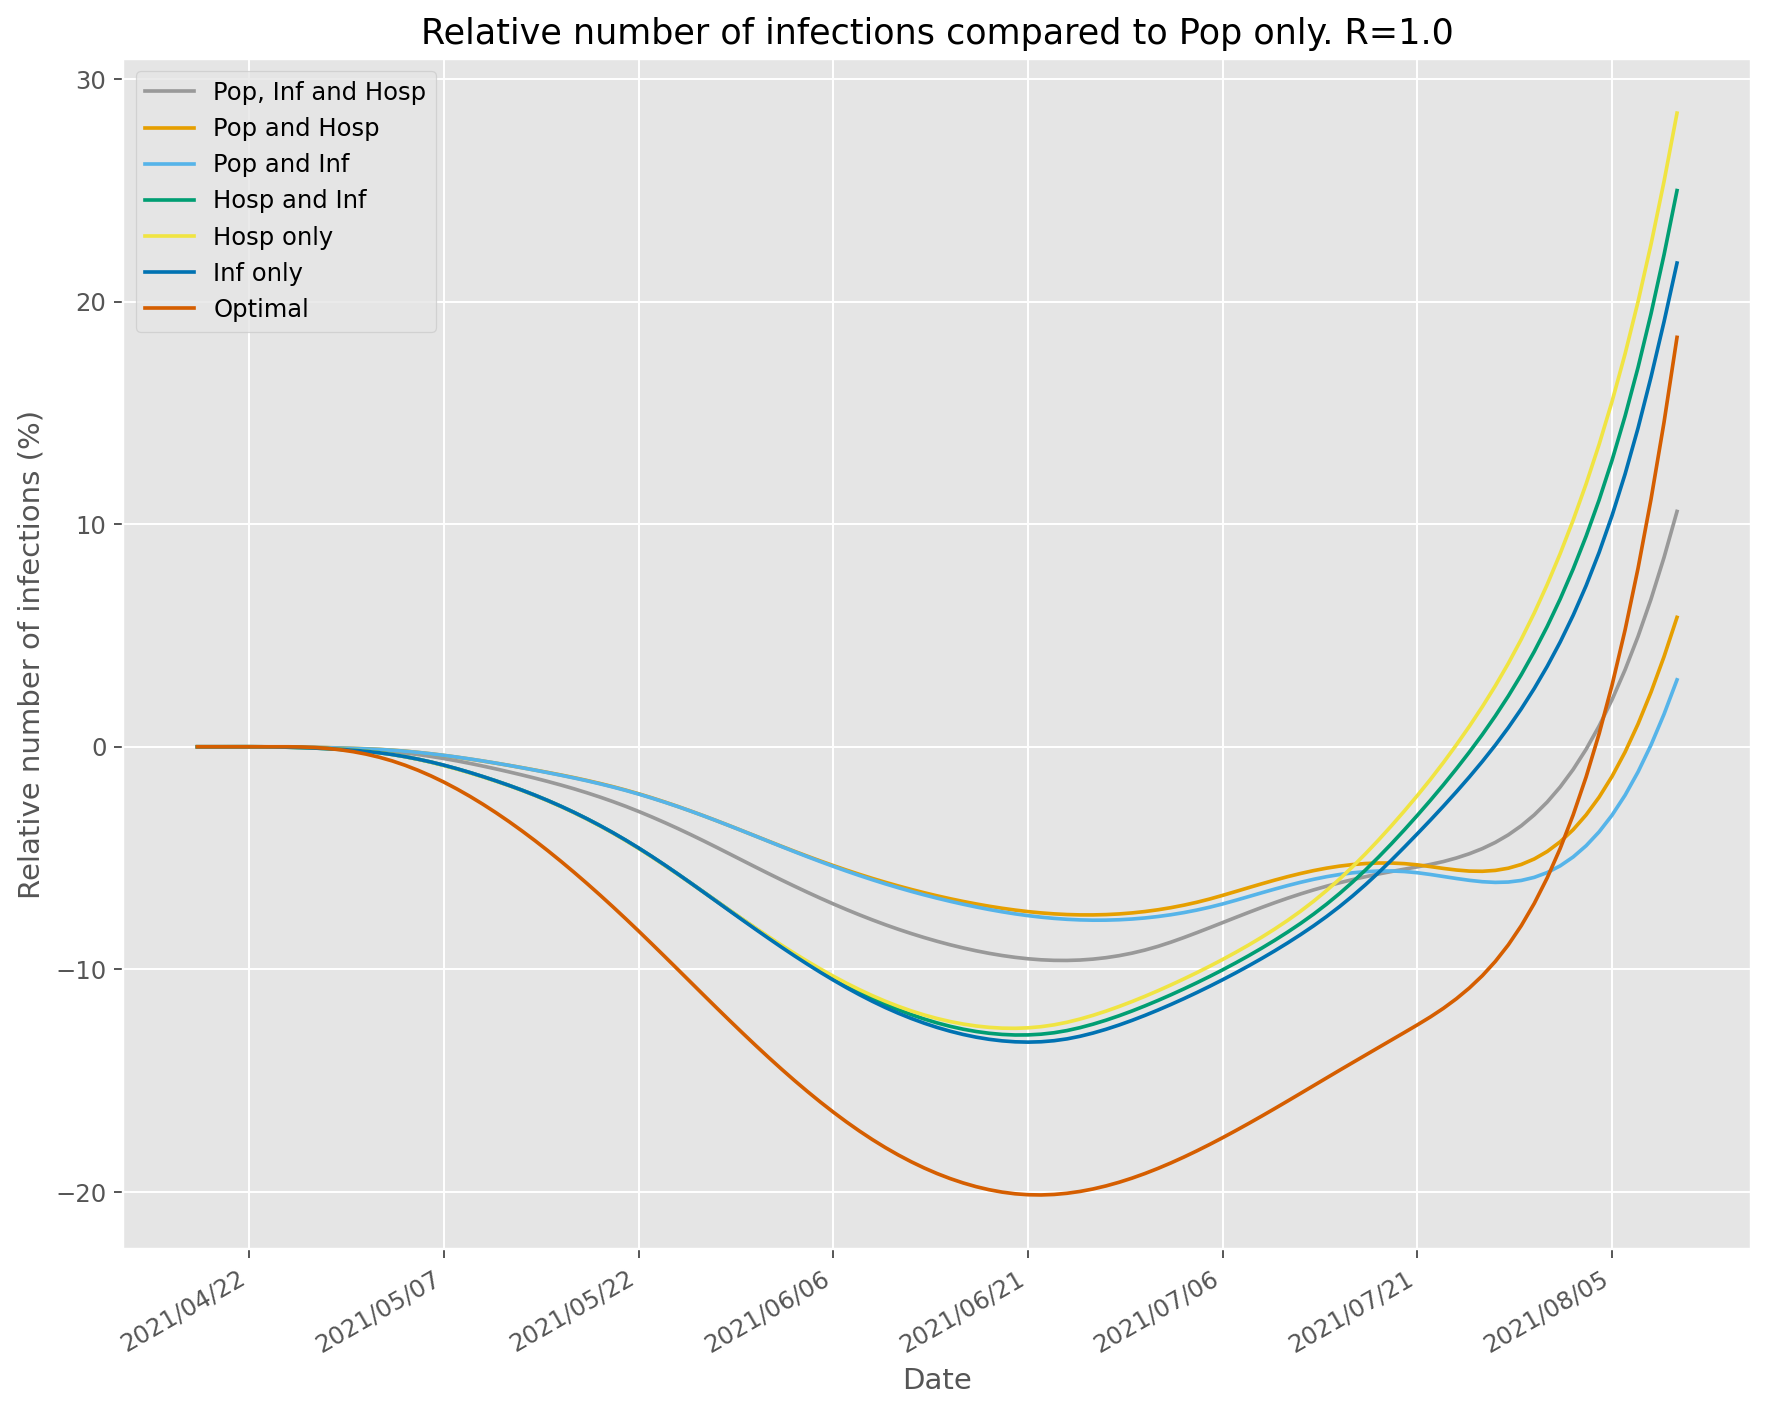

In [35]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[1], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Optimal: -9.654955964752398
Inf only: -3.074778349721008
Pop and Inf: -2.681478685299421
Pop, Inf and Hosp: -2.6674207743687006
Hosp and Inf: -2.632455703094605
Pop and Hosp: -2.3766101996820943
Hosp only: -2.17279768133809


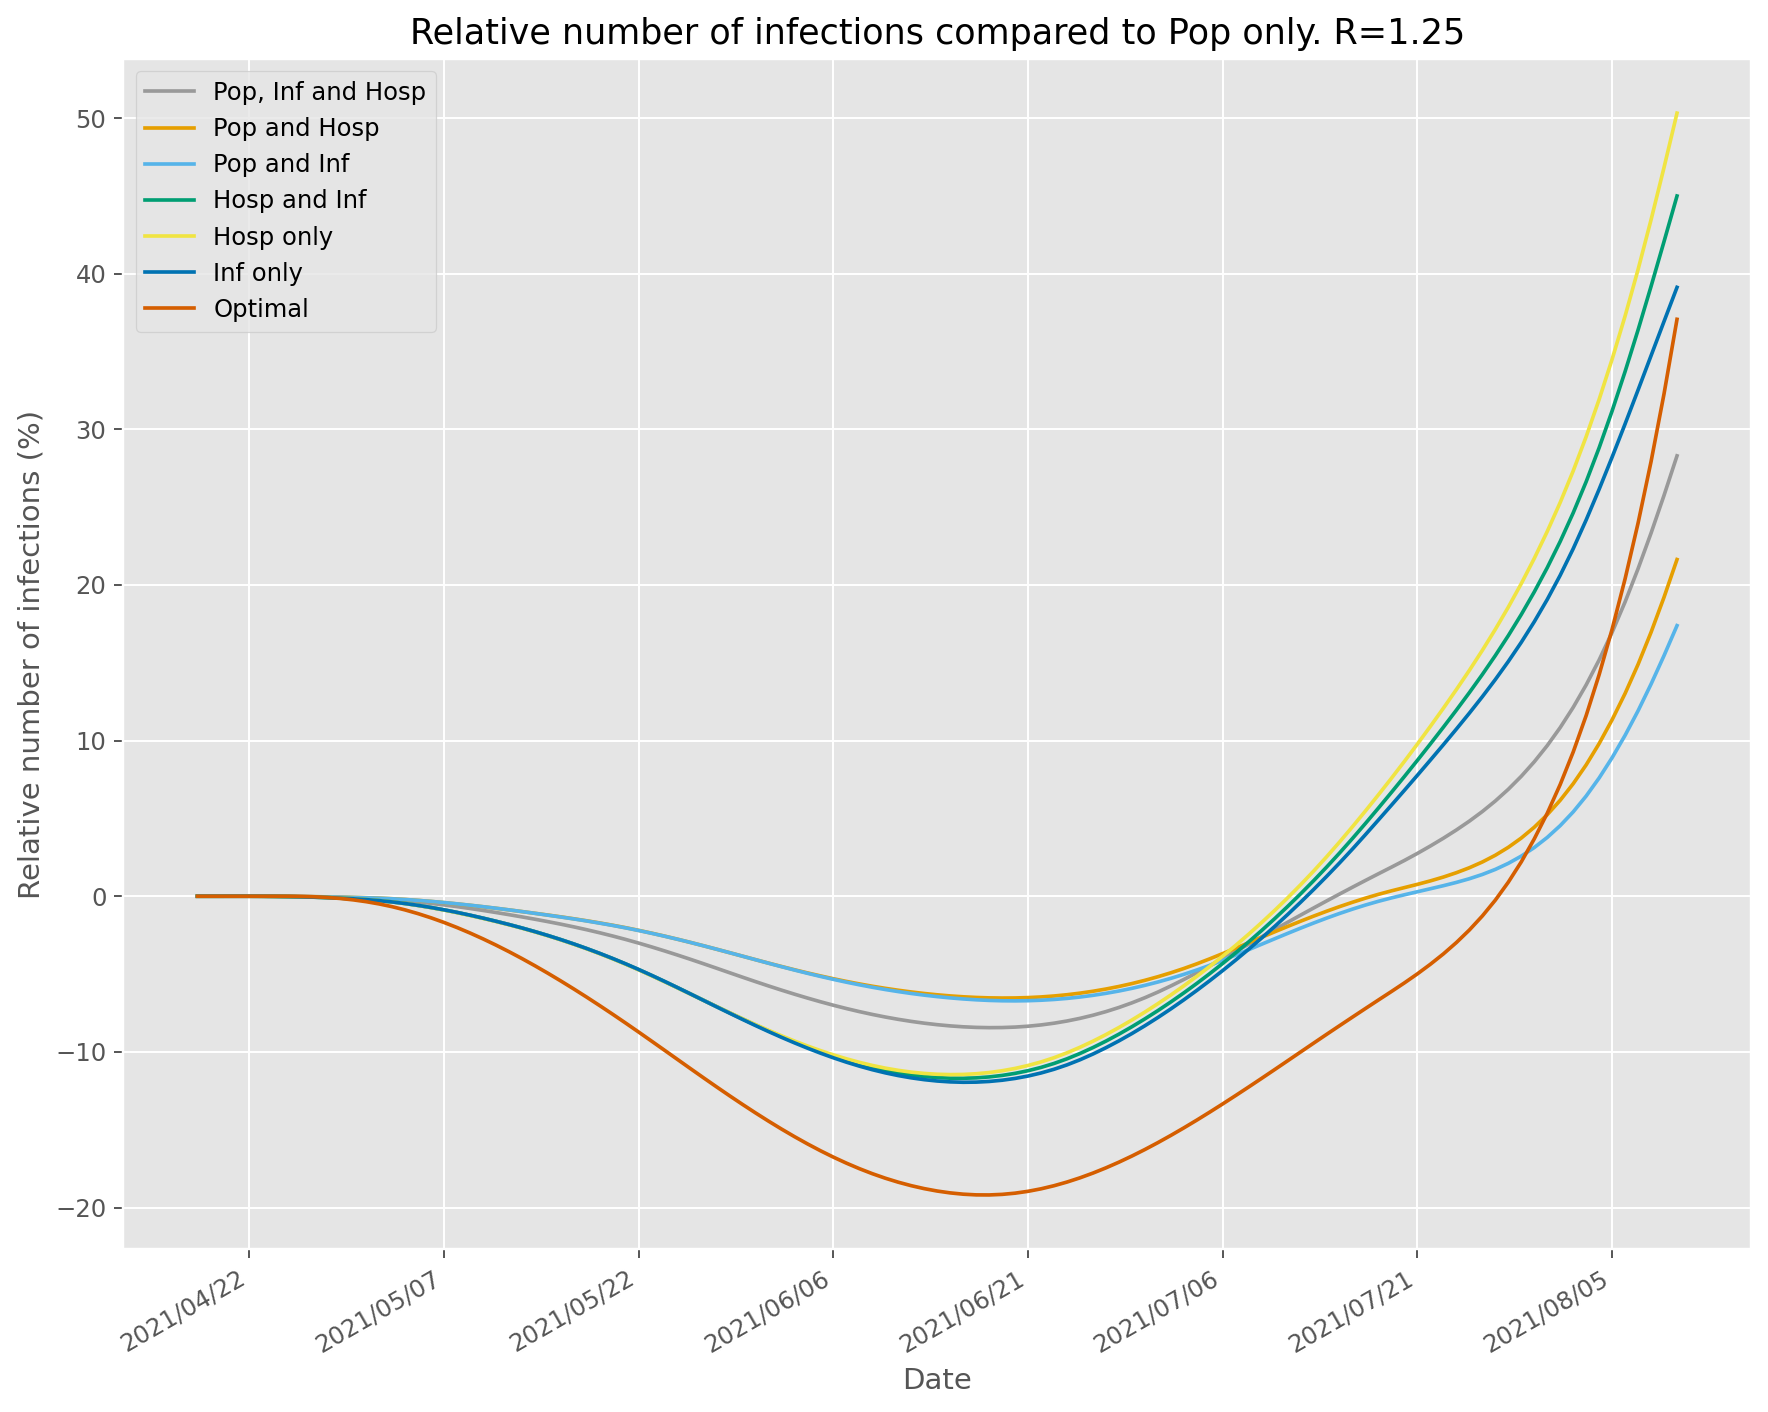

In [36]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[2], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()

Optimal: -1.449051929248224
Pop and Inf: 0.2000168103979183
Pop and Hosp: 0.5683314700922093
Pop, Inf and Hosp: 0.8440227995032856
Inf only: 1.228263559578835
Hosp and Inf: 1.6673332389304685
Hosp only: 2.129332874263179


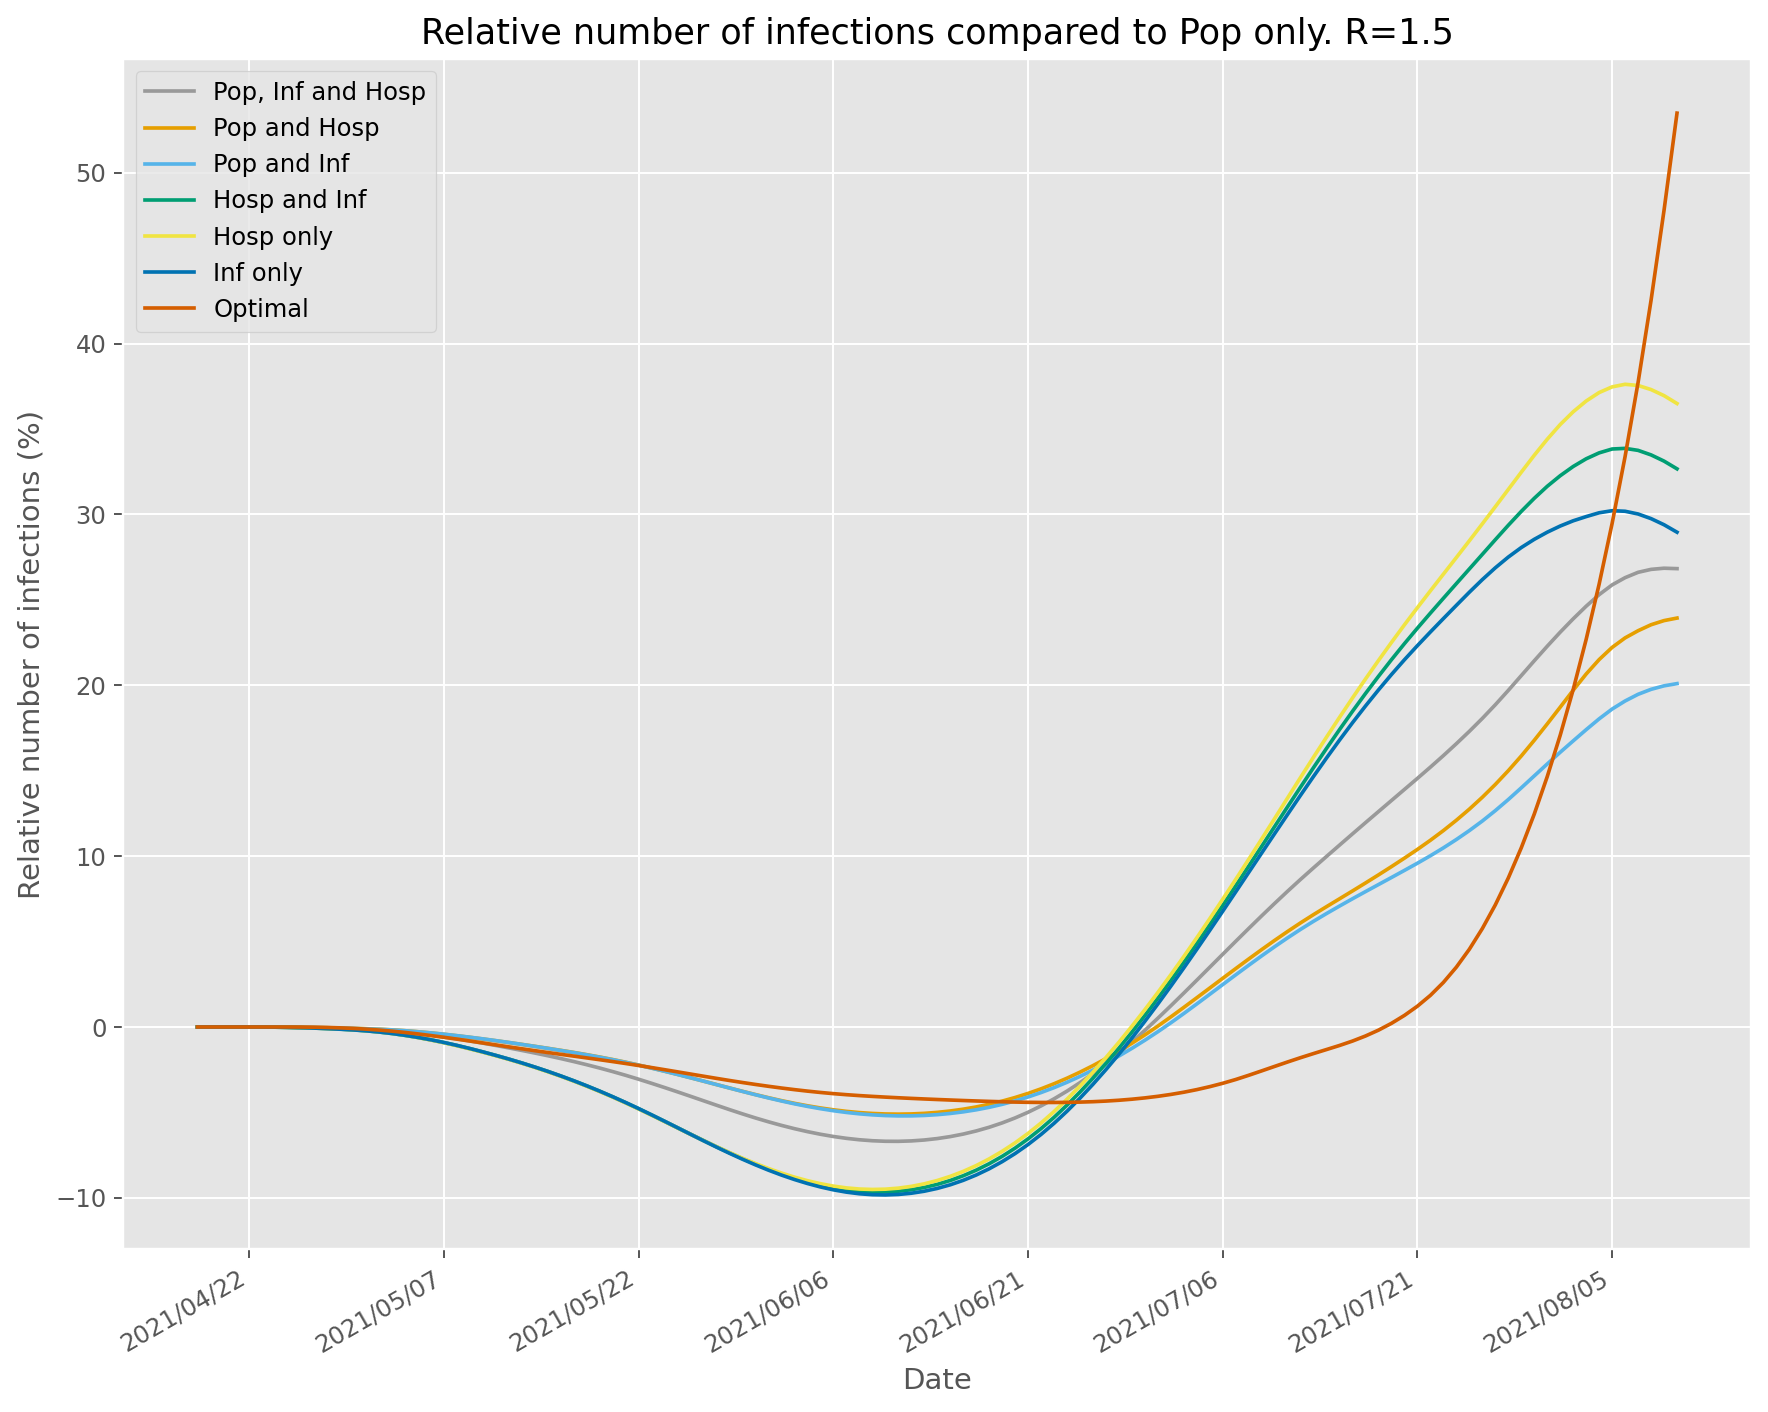

In [37]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=plot_interval))

ax = plot_results(ax, r=r_experiments[3], metric='infections', all_results=all_results, t0=t0, T=T)

fig.autofmt_xdate()